In [177]:
import pyodbc
server = 'localhost' 
database = 'ma_charity_small' 
username = 'root' 
password = '1234567890sos' 
cnxn = pyodbc.connect('DRIVER={MySQL ODBC 8.0 Unicode Driver};SERVER='+server+';DATABASE='+database+';UID='+username+';PWD='+ password)
cursor = cnxn.cursor()

In [178]:
print(pyodbc.drivers())

['SQL Server', 'SQL Server Native Client 10.0', 'PostgreSQL ANSI(x64)', 'PostgreSQL Unicode(x64)', 'ODBC Driver 17 for SQL Server', 'MySQL ODBC 8.0 ANSI Driver', 'MySQL ODBC 8.0 Unicode Driver']


In [179]:
import pandas as pd
import pymysql

def get_df_from_db(sql):
    cursor = connection.cursor()
    cursor.execute(sql)
    data = cursor.fetchall()
    columnDes = cursor.description
    columnNames = [columnDes[i][0] for i in range(len(columnDes))]
    df = pd.DataFrame([list(i) for i in data],columns=columnNames)
    return df

def get_df_from_db_1(sql):
    return pd.read_sql(sql, connection)

connection = pymysql.connect(host='localhost'
                           , port=3306
                           , db='ma_charity_small'
                           , user='root'
                           , passwd='1234567890sos'
                           , charset='utf8')

In [180]:
# for test
a = "select * from segments;"
segments = get_df_from_db_1(a)
print(segments['segment']==kind[1])

0         False
1         False
2         False
3         False
4         False
          ...  
281045    False
281046    False
281047    False
281048    False
281049    False
Name: segment, Length: 281050, dtype: bool


In [181]:
query = '''SELECT
  s.segment,
  COUNT(DISTINCT(s.contact_id)) AS 'numdonors',
  COUNT(a.amount)               AS 'numdonations',
  CEILING(AVG(a.amount))        AS 'avgamount',
  CEILING(SUM(a.amount))        AS 'totalgenerosity'
FROM
  segments s,
  periods p,
  acts a
WHERE
  (s.contact_id = a.contact_id) AND
  (s.period_id = 1) AND
  (p.period_id = 0) AND
  (a.act_date >= p.first_day) AND
  (a.act_date <= p.last_day)
GROUP BY 1
ORDER BY totalgenerosity DESC;'''

segmentation = get_df_from_db_1(query)

In [182]:
segmentation

,segment,numdonors,numdonations,avgamount,totalgenerosity
0,AUTO,2235,25466,16,386911.0
1,TOP,1102,2404,99,235616.0
2,BOTTOM,3132,5084,31,154153.0
3,None,1719,3994,28,108334.0
4,WARM,718,1010,41,40608.0
5,NEW,480,827,43,34820.0
6,LOST,208,310,44,13493.0
7,COLD,144,208,38,7764.0


# Kmeans
## Preprocess Data First

### About First Act Date

In [183]:
first_act_date = '''
SELECT contact_id, period_id
FROM periods p,
     (SELECT contact_id, MIN(act_date) AS first_act
      FROM acts
      GROUP BY 1) AS f
WHERE (f.first_act <= p.last_day) AND
      (f.first_act >= p.first_day)
group by 1;
'''
first_act_period = get_df_from_db_1(first_act_date)

In [184]:
first_act_period

,contact_id,period_id
0,677620,6
1,683640,8
2,683850,1
3,683910,3
4,684280,0
...,...,...
16131,1531910,0
16132,1532000,0
16133,1532060,0
16134,1532070,0


### About Features from Acts

In [185]:
acts_features = get_df_from_db_1('select contact_id, sum(amount), act_type_id, payment_method_id, channel_id, count(campaign_id) from acts group by contact_id;')
acts_features

,contact_id,sum(amount),act_type_id,payment_method_id,channel_id,count(campaign_id)
0,0,40.00,DO,CH,MA,1
1,70,2.29,DO,CH,MA,0
2,90,3.81,DO,CH,MA,0
3,110,11.43,DO,CH,MA,1
4,120,3.81,DO,CH,MA,0
...,...,...,...,...,...,...
25545,1531910,35.00,DO,CB,WW,1
25546,1532000,10.00,DO,CB,WW,1
25547,1532060,10.00,DO,CB,WW,1
25548,1532070,30.00,DO,CB,WW,1


### About Features from Acts

In [186]:
for_total_amount = get_df_from_db_1('select contact_id, amount, act_type_id, payment_method_id, channel_id, count(campaign_id) from acts group by id;')
for_total_amount

,contact_id,amount,act_type_id,payment_method_id,channel_id,count(campaign_id)
0,0,40.00,DO,CH,MA,1
1,70,2.29,DO,CH,MA,0
2,90,3.81,DO,CH,MA,0
3,110,3.81,DO,CH,MA,0
4,110,7.62,DO,AU,MA,1
...,...,...,...,...,...,...
310704,1531910,35.00,DO,CB,WW,1
310705,1532000,10.00,DO,CB,WW,1
310706,1532060,10.00,DO,CB,WW,1
310707,1532070,30.00,DO,CB,WW,1


### About Total Donation Amount

In [187]:
total_amount = for_total_amount.groupby(by='contact_id').agg({'amount':sum}).reset_index()
total_amount

,contact_id,amount
0,0,40.00
1,70,2.29
2,90,3.81
3,110,11.43
4,120,3.81
...,...,...
25545,1531910,35.00
25546,1532000,10.00
25547,1532060,10.00
25548,1532070,30.00


### About Total Donation Counts

In [188]:
num_donations = for_total_amount.groupby(['contact_id']).count()
num_donations['num_donations'] = num_donations.amount
num_donations = num_donations['num_donations']
num_donations

contact_id
0          1
70         1
90         1
110        2
120        1
          ..
1531910    1
1532000    1
1532060    1
1532070    1
1532260    1
Name: num_donations, Length: 25550, dtype: int64

### Preprocess Actions

In [189]:
actions_features = get_df_from_db_1('select * from actions;')

In [190]:
actions_features

,id,contact_id,campaign_id,message_id,action_date
0,509,160,C28,C28-18,2009-05-14
1,510,160,C75,C75-18,2009-07-28
2,511,160,C73,C73-10,2009-09-23
3,512,160,C30,C30-4,2009-10-28
4,513,160,C61,C61-10,2009-12-23
...,...,...,...,...,...
677172,8488651,1522400,C186,C186-11,2018-04-25
677173,8488652,1522400,C189,C189-8,2018-05-15
677174,8488697,1522720,C189,C189-8,2018-05-15
677175,8488750,1523230,C189,C189-17,2018-05-15


In [191]:
query = '''
SELECT contact_id, campaign_count, period_id
FROM periods p,
     (select contact_id, count(campaign_id) as campaign_count, min(action_date) as first_act from actions group by contact_id) AS f
WHERE (f.first_act <= p.last_day) AND
      (f.first_act >= p.first_day)
group by 1;
'''
actions_features_2 = get_df_from_db_1(query)

In [192]:
actions_features_2

,contact_id,campaign_count,period_id
0,160,28,9
1,410,67,10
2,440,34,10
3,450,54,10
4,690,45,10
...,...,...,...
22679,1521570,1,0
22680,1522400,8,0
22681,1522720,1,0
22682,1523230,1,0


## Merging data

In [193]:
out = pd.merge(acts_features, first_act_period, how='left', left_on='contact_id', right_on='contact_id',
         left_index=False, right_index=False, sort=True,
         suffixes=('_x', '_y'), copy=True, indicator=False)
out.period_id.fillna(11, inplace=True)

In [194]:
out2 = pd.merge(out, total_amount, how='left', left_on='contact_id', right_on='contact_id',
         left_index=False, right_index=False, sort=True,
         suffixes=('_x', '_y'), copy=True, indicator=False)
out2 = out2.drop('sum(amount)', axis=1)

In [195]:
out3 = pd.merge(out2, actions_features_2, how='left', left_on='contact_id', right_on='contact_id',
         left_index=False, right_index=False, sort=True,
         suffixes=('_x', '_y'), copy=True, indicator=False)
out3.period_id_y.fillna(11, inplace=True)
out3.campaign_count.fillna(0, inplace=True)

In [196]:
out3

,contact_id,act_type_id,payment_method_id,channel_id,count(campaign_id),period_id_x,amount,campaign_count,period_id_y
0,0,DO,CH,MA,1,11.0,40.00,0.0,11.0
1,70,DO,CH,MA,0,11.0,2.29,0.0,11.0
2,90,DO,CH,MA,0,11.0,3.81,0.0,11.0
3,110,DO,CH,MA,1,11.0,11.43,0.0,11.0
4,120,DO,CH,MA,0,11.0,3.81,0.0,11.0
...,...,...,...,...,...,...,...,...,...
25545,1531910,DO,CB,WW,1,0.0,35.00,0.0,11.0
25546,1532000,DO,CB,WW,1,0.0,10.00,0.0,11.0
25547,1532060,DO,CB,WW,1,0.0,10.00,0.0,11.0
25548,1532070,DO,CB,WW,1,0.0,30.00,0.0,11.0


### Now use groupby to have total donation money

In [197]:
total_amount

,contact_id,amount
0,0,40.00
1,70,2.29
2,90,3.81
3,110,11.43
4,120,3.81
...,...,...
25545,1531910,35.00
25546,1532000,10.00
25547,1532060,10.00
25548,1532070,30.00


## One hot encoder

In [198]:
out4 = pd.get_dummies(out3)

In [199]:
out4

,contact_id,count(campaign_id),period_id_x,amount,campaign_count,period_id_y,act_type_id_DO,act_type_id_PA,payment_method_id_AU,payment_method_id_CB,payment_method_id_CH,payment_method_id_ES,payment_method_id_PR,payment_method_id_VI,channel_id_MA,channel_id_WW
0,0,1,11.0,40.00,0.0,11.0,1,0,0,0,1,0,0,0,1,0
1,70,0,11.0,2.29,0.0,11.0,1,0,0,0,1,0,0,0,1,0
2,90,0,11.0,3.81,0.0,11.0,1,0,0,0,1,0,0,0,1,0
3,110,1,11.0,11.43,0.0,11.0,1,0,0,0,1,0,0,0,1,0
4,120,0,11.0,3.81,0.0,11.0,1,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25545,1531910,1,0.0,35.00,0.0,11.0,1,0,0,1,0,0,0,0,0,1
25546,1532000,1,0.0,10.00,0.0,11.0,1,0,0,1,0,0,0,0,0,1
25547,1532060,1,0.0,10.00,0.0,11.0,1,0,0,1,0,0,0,0,0,1
25548,1532070,1,0.0,30.00,0.0,11.0,1,0,0,1,0,0,0,0,0,1


In [200]:
# add number of donations
out_s = pd.merge(out4, num_donations, how='left', left_on='contact_id', right_on='contact_id')
out_s

,contact_id,count(campaign_id),period_id_x,amount,campaign_count,period_id_y,act_type_id_DO,act_type_id_PA,payment_method_id_AU,payment_method_id_CB,payment_method_id_CH,payment_method_id_ES,payment_method_id_PR,payment_method_id_VI,channel_id_MA,channel_id_WW,num_donations
0,0,1,11.0,40.00,0.0,11.0,1,0,0,0,1,0,0,0,1,0,1
1,70,0,11.0,2.29,0.0,11.0,1,0,0,0,1,0,0,0,1,0,1
2,90,0,11.0,3.81,0.0,11.0,1,0,0,0,1,0,0,0,1,0,1
3,110,1,11.0,11.43,0.0,11.0,1,0,0,0,1,0,0,0,1,0,2
4,120,0,11.0,3.81,0.0,11.0,1,0,0,0,1,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25545,1531910,1,0.0,35.00,0.0,11.0,1,0,0,1,0,0,0,0,0,1,1
25546,1532000,1,0.0,10.00,0.0,11.0,1,0,0,1,0,0,0,0,0,1,1
25547,1532060,1,0.0,10.00,0.0,11.0,1,0,0,1,0,0,0,0,0,1,1
25548,1532070,1,0.0,30.00,0.0,11.0,1,0,0,1,0,0,0,0,0,1,1


# Start KMeans

In [201]:
import matplotlib.pyplot as plt
from sklearn.datasets.samples_generator import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import warnings
import copy
from collections import Counter
warnings.filterwarnings("ignore")

## Scale the data

In [202]:
X_2 = MinMaxScaler().fit_transform(out_s)

scaler = MinMaxScaler()
print(scaler.fit(out_s))

MinMaxScaler()


In [203]:
out_ss = pd.DataFrame(X_2)
out_ss.columns = out_s.columns

In [204]:
out_ss

,contact_id,count(campaign_id),period_id_x,amount,campaign_count,period_id_y,act_type_id_DO,act_type_id_PA,payment_method_id_AU,payment_method_id_CB,payment_method_id_CH,payment_method_id_ES,payment_method_id_PR,payment_method_id_VI,channel_id_MA,channel_id_WW,num_donations
0,0.000000,0.005076,1.0,0.000572,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.00000
1,0.000046,0.000000,1.0,0.000032,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.00000
2,0.000059,0.000000,1.0,0.000054,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.00000
3,0.000072,0.005076,1.0,0.000163,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.00495
4,0.000078,0.000000,1.0,0.000054,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25545,0.999772,0.005076,0.0,0.000500,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.00000
25546,0.999830,0.005076,0.0,0.000142,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.00000
25547,0.999869,0.005076,0.0,0.000142,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.00000
25548,0.999876,0.005076,0.0,0.000429,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.00000


In [205]:
out_s2 = copy.deepcopy(out_s)
out_s2.amount = out_ss.amount

In [206]:
Counter(out_ss.act_type_id_DO)

Counter({1.0: 24755, 0.0: 795})

In [207]:
pd.DataFrame(scaler.transform(out_s))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,0.000000,0.005076,1.0,0.000572,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.00000
1,0.000046,0.000000,1.0,0.000032,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.00000
2,0.000059,0.000000,1.0,0.000054,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.00000
3,0.000072,0.005076,1.0,0.000163,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.00495
4,0.000078,0.000000,1.0,0.000054,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25545,0.999772,0.005076,0.0,0.000500,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.00000
25546,0.999830,0.005076,0.0,0.000142,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.00000
25547,0.999869,0.005076,0.0,0.000142,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.00000
25548,0.999876,0.005076,0.0,0.000429,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.00000


In [208]:
# Have a look at the Calinski-Harabasz Index
y_pred = KMeans(n_clusters=9, random_state=9).fit_predict(out_s.iloc[:,2:])
print(calinski_harabasz_score(out_s.iloc[:,2:], y_pred))

92329.81667344683


In [209]:
# y_pred = KMeans(n_clusters=10, random_state=9).fit_predict(out_s.iloc[:,2:])
# # 分别尝试n_cluses=2\3\4,然后查看聚类效果

# # 用Calinski-Harabasz Index评估的聚类分数
# print(calinski_harabasz_score(out_s.iloc[:,2:], y_pred))

### See how many donors we have in each segmentation

In [210]:
from collections import Counter
Counter(y_pred)

Counter({0: 18135, 2: 725, 7: 4659, 5: 1747, 8: 226, 4: 42, 1: 4, 3: 11, 6: 1})

In [211]:
out_s['kind'] = y_pred

### Make 1, 5, 8 segmentation kinds all into kind 3

In [212]:
# 将3,1,5,8这四类全部划分成第3类
for i in range(len(out_s)):
    if out_s.iloc[i, -1] in [1, 5, 8]:
        out_s.iloc[i, -1] = 3

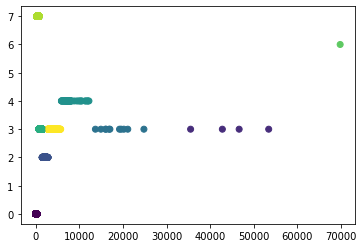

In [213]:
plt.scatter(out_s.iloc[:, 3].values, out_s.iloc[:, -1].values, c=y_pred)
plt.show()

In [214]:
# Make number 1-6
set(list(out_s.kind))
for i in range(len(out_s)):
    if out_s.kind[i] == 6:
        out_s.iloc[i, -1] == 1
    elif out_s.iloc[i, -1] == 7:
        out_s.iloc[i, -1] == 5

In [215]:
out_s

,contact_id,count(campaign_id),period_id_x,amount,campaign_count,period_id_y,act_type_id_DO,act_type_id_PA,payment_method_id_AU,payment_method_id_CB,payment_method_id_CH,payment_method_id_ES,payment_method_id_PR,payment_method_id_VI,channel_id_MA,channel_id_WW,num_donations,kind
0,0,1,11.0,40.00,0.0,11.0,1,0,0,0,1,0,0,0,1,0,1,0
1,70,0,11.0,2.29,0.0,11.0,1,0,0,0,1,0,0,0,1,0,1,0
2,90,0,11.0,3.81,0.0,11.0,1,0,0,0,1,0,0,0,1,0,1,0
3,110,1,11.0,11.43,0.0,11.0,1,0,0,0,1,0,0,0,1,0,2,0
4,120,0,11.0,3.81,0.0,11.0,1,0,0,0,1,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25545,1531910,1,0.0,35.00,0.0,11.0,1,0,0,1,0,0,0,0,0,1,1,0
25546,1532000,1,0.0,10.00,0.0,11.0,1,0,0,1,0,0,0,0,0,1,1,0
25547,1532060,1,0.0,10.00,0.0,11.0,1,0,0,1,0,0,0,0,0,1,1,0
25548,1532070,1,0.0,30.00,0.0,11.0,1,0,0,1,0,0,0,0,0,1,1,0


In [216]:
Counter(list(out_s.kind))

Counter({0: 18135, 2: 725, 7: 4659, 3: 1988, 4: 42, 6: 1})

In [217]:
out5 = out_s.iloc[:, [0, 3, -2, -1]]

In [218]:
out6 = out5.groupby(['kind']).sum()

In [219]:
# num_donations这里是总共的捐款次数（同一类别的），amount也可以用，同一类别的全部捐款
out6

,contact_id,amount,num_donations
kind,,,
0,15258458380,1427035.43,66253
2,505663650,1427774.54,46559
3,1471147850,3029966.95,95260
4,27247570,337313.00,2932
6,885450,69823.97,13
7,3746905600,2094540.50,99692


In [220]:
out7 = out5.groupby(['kind']).count()

In [221]:
out8 = pd.merge(out6, out7, how='left', left_on='kind', right_on='kind')
out8 = out8.drop(['contact_id_x', 'amount_y', 'num_donations_y'], axis=1)

## Make final changes and then send it to R

In [222]:
out8['segment'] = out8.index
out8['numdonors'] = out8.contact_id_y
out8['numdonations'] = out8.num_donations_x
out8['avgamount'] = out8.amount_x/out8.num_donations_x
out8['totalgenerosity'] = out8.amount_x
out8['numdonors_pc'] = out8.contact_id_y/sum(list(out8.contact_id_y))
out8['totalgenerosity_pc'] = out8.totalgenerosity/sum(list(out8.totalgenerosity))
out8.drop(['amount_x', 'num_donations_x', 'contact_id_y'], axis=1, inplace=True)
# out8 = out8.set_index('segment')
out8['ratio'] = out8.totalgenerosity/out8.numdonors
out8 = out8.sort_values(by="ratio",ascending=False)

In [232]:
out8

,segment,numdonors,numdonations,avgamount,totalgenerosity,numdonors_pc,totalgenerosity_pc,ratio
kind,,,,,,,,
6,6,1,13,5371.074615,69823.97,0.000039,0.008326,69823.970000
4,4,42,2932,115.045362,337313.00,0.001644,0.040221,8031.261905
2,2,725,46559,30.665919,1427774.54,0.028376,0.170248,1969.344193
3,3,1988,95260,31.807337,3029966.95,0.077808,0.361293,1524.128244
7,7,4659,99692,21.010116,2094540.50,0.182348,0.249753,449.568684
0,0,18135,66253,21.539182,1427035.43,0.709785,0.170160,78.689574


# Export to CSV

In [223]:
out8.to_csv('./kmeans_first_outcome.csv')

In [228]:
# For descrption, corresponding kind
out_s.groupby(['kind']).mean()
# average amount per kind

,contact_id,count(campaign_id),period_id_x,amount,campaign_count,period_id_y,act_type_id_DO,act_type_id_PA,payment_method_id_AU,payment_method_id_CB,payment_method_id_CH,payment_method_id_ES,payment_method_id_PR,payment_method_id_VI,channel_id_MA,channel_id_WW,num_donations
kind,,,,,,,,,,,,,,,,,
0,841381.768955,3.430383,6.493190,78.689574,18.914144,6.361070,0.974028,0.025972,0.006782,0.136201,0.822774,0.003253,0.025972,0.005018,0.903060,0.096940,3.653322
2,697467.103448,60.244138,9.684138,1969.344193,51.823448,9.019310,0.973793,0.026207,0.004138,0.067586,0.900690,0.001379,0.026207,0.000000,0.988966,0.011034,64.219310
3,740014.009054,45.370724,9.308350,1524.128244,49.949698,8.689135,0.972837,0.027163,0.015594,0.065895,0.889839,0.000503,0.027163,0.001006,0.980885,0.019115,47.917505
4,648751.666667,64.571429,9.880952,8031.261905,50.333333,9.142857,0.976190,0.023810,0.000000,0.023810,0.952381,0.000000,0.023810,0.000000,1.000000,0.000000,69.809524
6,885450.000000,11.000000,10.000000,69823.970000,58.000000,10.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,13.000000
7,804229.577162,20.586177,7.983473,449.568684,41.757888,7.495600,0.946340,0.053660,0.004937,0.089290,0.849324,0.001717,0.053660,0.001073,0.955999,0.044001,21.397725


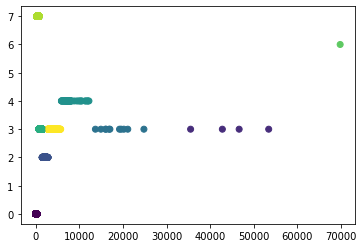

In [229]:
plt.scatter(out_s.iloc[:, 3].values, out_s.iloc[:, -1].values, c=y_pred)
plt.show()

In [231]:
out_s.describe()

,contact_id,count(campaign_id),period_id_x,amount,campaign_count,period_id_y,act_type_id_DO,act_type_id_PA,payment_method_id_AU,payment_method_id_CB,payment_method_id_CH,payment_method_id_ES,payment_method_id_PR,payment_method_id_VI,channel_id_MA,channel_id_WW,num_donations,kind
count,2.555000e+04,25550.000000,25550.000000,25550.000000,25550.000000,25550.000000,25550.000000,25550.000000,25550.000000,25550.000000,25550.000000,25550.000000,25550.000000,25550.000000,25550.000000,25550.000000,25550.000000,25550.000000
mean,8.223213e+05,11.534951,7.080235,328.236962,26.481487,6.829237,0.968885,0.031115,0.007084,0.120039,0.835225,0.002701,0.031115,0.003836,0.921370,0.078630,12.160822,1.573425
std,2.681703e+05,21.538799,3.926212,1009.151747,20.298918,3.643933,0.173633,0.173633,0.083870,0.325014,0.370985,0.051898,0.173633,0.061815,0.269166,0.269166,22.781715,2.702069
min,0.000000e+00,0.000000,0.000000,0.060000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,7.538625e+05,1.000000,4.000000,30.490000,9.000000,4.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
50%,9.073050e+05,3.000000,8.000000,100.000000,22.000000,8.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,4.000000,0.000000
75%,9.731775e+05,11.000000,11.000000,320.000000,41.000000,10.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,11.000000,3.000000
max,1.532260e+06,197.000000,11.000000,69823.970000,109.000000,11.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,203.000000,7.000000
